## Library

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import sys
import os
os.environ["SCIPY_ARRAY_API"] = "1"

import scanpy as sc
import torch
import numpy as np
import time
import torch.nn as nn

from tqdm.auto import tqdm
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt

sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [2]:
local_package_path = "../models/"
sys.path.insert(0,local_package_path)

import scarches as sca
from scarches.models.tstscope.trainer import make_tcr_dataset, loss

 captum (see https://github.com/pytorch/captum).


## Load the demo dataset and GP matrix

In [ ]:
# please download the demo dataset from https://figshare.com/articles/dataset/donor2_tcr_emb_SeuObj/24022223
adata = sc.read('../data/donor2_tcr_emb_SeuObj.h5ad')
adata

AnnData object with n_obs × n_vars = 33804 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'pepLabel', 'tra', 'trb'
    var: 'name'
    obsm: 'scCVC_emb', 'tcrbert_emb', 'tcrbert_ft_emb'

In [4]:
# make sure the data is count matrix
adata.X.max()

1459.0

In [14]:
# save counts layer
adata.layers["counts"] = adata.X.copy()
adata.obs['batch'] = 'donor2'

In [ ]:
# check Gene Program Matrix
gp_path = "../data/Tcell_function_0326.gmt"

with open(gp_path) as f:
    p_f = [l.upper() for l in f]
    gp_matrix = [l.strip('\n').split() for l in p_f]
    gp_matrix = [[term[0].split('_', 1)[-1][:30]]+term[1:] for term in gp_matrix if term]
print(f"Total {len(gp_matrix)} gene sets")

for gp_term in gp_matrix:
    gp_term_name = gp_term[0]
    gp_term_len = len(gp_term[1:])
    print(f"    {gp_term_name}: {gp_term_len} genes")

Total 50 gene sets
    MODULE_1: 20 genes
    MODULE_2: 20 genes
    MODULE_3: 25 genes
    MODULE_4: 33 genes
    MODULE_5: 7 genes
    MODULE_6: 16 genes
    MODULE_7: 14 genes
    MODULE_8: 12 genes
    MODULE_9: 24 genes
    NAÏVE: 10 genes
    ACTIVATION_EFFECTOR_FUNCTION: 40 genes
    PROGENITOR_EXHAUSTION: 22 genes
    TERMINAL_EXHAUSTION: 33 genes
    TCR_SIGNALING: 56 genes
    CYTOTOXICITY: 23 genes
    CYTOKINE_RECEPTOR: 14 genes
    CHEMOKINE_RECEPTOR: 16 genes
    ANERGY: 13 genes
    NFKB_SIGNALING: 11 genes
    STRESS_RESPONSE: 163 genes
    MAPK_SIGNALING: 20 genes
    ADHESION: 14 genes
    IFN_RESPONSE: 50 genes
    OXIDATIVE_PHOSPHORYLATION: 118 genes
    GLYCOLYSIS: 18 genes
    FATTY_ACID_METABOLISM: 14 genes
    SENESCENCE: 11 genes
    PRO_APOPTOSIS: 8 genes
    ANTI_APOPTOSIS: 6 genes
    QUIESCENCE: 5 genes
    PROLIFERATION: 16 genes
    NEOTCR_CD8: 220 genes
    TUMOR_SPECIFIC: 72 genes
    TUMOR_REACTIVITY: 50 genes
    NEOTCRPBL: 151 genes
    TCM: 24 genes

In [ ]:
# load GP-gene filter
sca.utils.add_annotations(adata,'../data/Tcell_function_0326.gmt', min_genes=0, clean=True)
print(adata.varm['I'].shape)
print(adata.uns['terms'])
adata

(33538, 50)
['MODULE_1', 'MODULE_2', 'MODULE_3', 'MODULE_4', 'MODULE_5', 'MODULE_6', 'MODULE_7', 'MODULE_8', 'MODULE_9', 'NAÏVE', 'ACTIVATION_EFFECTOR_FUNCTION', 'PROGENITOR_EXHAUSTION', 'TERMINAL_EXHAUSTION', 'TCR_SIGNALING', 'CYTOTOXICITY', 'CYTOKINE_RECEPTOR', 'CHEMOKINE_RECEPTOR', 'ANERGY', 'NFKB_SIGNALING', 'STRESS_RESPONSE', 'MAPK_SIGNALING', 'ADHESION', 'IFN_RESPONSE', 'OXIDATIVE_PHOSPHORYLATION', 'GLYCOLYSIS', 'FATTY_ACID_METABOLISM', 'SENESCENCE', 'PRO_APOPTOSIS', 'ANTI_APOPTOSIS', 'QUIESCENCE', 'PROLIFERATION', 'NEOTCR_CD8', 'TUMOR_SPECIFIC', 'TUMOR_REACTIVITY', 'NEOTCRPBL', 'TCM', 'TRM', 'EARLY_TEM', 'TEM', 'TEMRA', 'TCF_TEX', 'GZMK_TEX', 'TERM_TEX', 'OXPHOS_TEX', 'NME1_T', 'MAIT', 'TC17', 'KIR_EOMES_NK_LIKE', 'KIR_TXK_NK_LIKE', 'ISG_T']


AnnData object with n_obs × n_vars = 33804 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'pepLabel', 'tra', 'trb', 'batch'
    var: 'name'
    uns: 'terms'
    obsm: 'scCVC_emb', 'tcrbert_emb', 'tcrbert_ft_emb'
    varm: 'I'
    layers: 'counts'

In [ ]:
# GP-gene filter
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)
adata.X = adata.layers["counts"].copy()
adata.X = adata.X.todense()
adata.X = adata.X.astype(np.float32)
adata

AnnData object with n_obs × n_vars = 33804 × 1123
    obs: 'nCount_RNA', 'nFeature_RNA', 'pepLabel', 'tra', 'trb', 'batch'
    var: 'name'
    uns: 'terms'
    obsm: 'scCVC_emb', 'tcrbert_emb', 'tcrbert_ft_emb'
    varm: 'I'
    layers: 'counts'

In [17]:
# get tcr emb and clonotype information
adata.obsm['tcremb'] = adata.obsm['tcrbert_ft_emb']
_, adata.obs['tcrlabel'] = np.unique(adata.obs['trb'], return_inverse=True)
print(len(np.unique(adata.obs['tcrlabel'])))

2520


## Model Training and Inference

In [21]:
## functions for training
def train_one_epoch(model, dataloader, optimizer, loss_fn, alpha_coeff, device):
    """
    负责执行一个 Epoch 的训练逻辑，包含 Batch 级别的进度条。
    """
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(dataloader, desc="  Batch Progress", leave=False, unit="batch")
    
    for batch_data in pbar:
        for key, batch in batch_data.items():
            batch_data[key] = batch.to(device)
            
        # 计算 Loss
        train_loss, gene_recon_loss, tcr_recon_loss, tcr_hsic_loss, kl_loss, align_loss = loss_fn(
            model=model,
            total_batch=batch_data,
            coeff=alpha_coeff,
            align_weight=1,
            tcr_weight=0.001
        )
        
        # 处理 BatchNorm 的冻结逻辑 (针对 fine-tuning 等场景)
        if hasattr(model, 'freeze') and model.freeze:
            for name, module in model.named_modules():
                if isinstance(module, nn.BatchNorm1d):
                    if not module.weight.requires_grad:
                        module.affine = False
                        module.track_running_stats = False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        current_loss = train_loss.item()
        running_loss += current_loss
        
        # 实时在进度条尾部显示当前 Batch 的 Loss
        pbar.set_postfix({'batch_loss': f"{current_loss:.4f}"})
        
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, alpha_coeff, device):
    """
    负责模型验证逻辑。
    """
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_data in dataloader:
            for key, batch in batch_data.items():
                batch_data[key] = batch.to(device)
            
            val_loss_tuple = loss_fn(
                model=model,
                total_batch=batch_data,
                coeff=alpha_coeff,
                align_weight=1,
                tcr_weight=0.001
            )
            # loss 函数返回的是 tuple，第一个元素是总 loss
            val_loss = val_loss_tuple[0]
            running_loss += val_loss.item()
            
    return running_loss / len(dataloader)

def train_pipeline(model, train_loader, val_loader, optimizer, n_epochs, device, loss_fn):
    """
    主训练管道，负责 Epoch 循环和总体进度展示。
    """
    model.to(device)
    
    print("Starting training...")
    # 总体 Epoch 进度条
    epoch_pbar = tqdm(range(n_epochs), desc="Overall Progress", unit="epoch")
    
    history = {'train_loss': [], 'val_loss': [], 'epoch_times': []}
    
    for epoch in epoch_pbar:
        start_time = time.time()
        
        # 动态计算 alpha_coeff (KL loss 的权重)
        alpha_coeff = min(0.5 * epoch / 50, 0.5)
        
        # 训练阶段
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, alpha_coeff, device)
        
        # 验证阶段
        val_loss = validate(model, val_loader, loss_fn, alpha_coeff, device)
        
        end_time = time.time()
        epoch_duration = end_time - start_time
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epoch_times'].append(epoch_duration)
        
        # 更新 Epoch 进度条的后缀信息，展示实时指标
        epoch_pbar.set_postfix({
            'Train Loss': f"{train_loss:.4f}",
            'Val Loss': f"{val_loss:.4f}",
            'Time/Epoch': f"{epoch_duration:.2f}s"
        })
        
    return history

In [19]:
# build model
tcremb_cvae = sca.models.TSTSCOPE(
    adata=adata,
    condition_key='batch', # condition
    hidden_layer_sizes=[256,256,256],
    recon_loss='nb',
    use_hsic=False
)
model = tcremb_cvae.model


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1123 256 0
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 50
Encoder Architecture:
	Input Layer in, out and cond: 768 256 0
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 50
Decoder Architecture:
	Masked linear layer in, cond, out:  50 1 1123
	with hard mask.
Last Decoder layer: softmax
Decoder Architecture:
	First Layer in, out and cond:  50 256 0
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Output Layer in/out:  256 768 



In [20]:
# build datasets
train_data, valid_data = make_tcr_dataset(
    adata,
    train_frac=0.9,
    condition_key='batch',
    condition_encoder=model.condition_encoder
)

Preparing (33804, 1123)
Instantiating dataset


In [22]:
# Configuration and Execution

# Set device
device = torch.device("cuda:2")

# Prepare DataLoaders
stratifier_weights = torch.tensor(train_data.stratifier_weights, device=device)
n_samples = len(train_data)
sampler = WeightedRandomSampler(stratifier_weights, num_samples=n_samples, replacement=True)

batch_size = 512
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=sampler)
dataloader_valid = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)

# Training Parameters
n_epochs = 100
lr = 1e-3
eps = 0.01
weight_decay = 0.0
torch.manual_seed(2024)

# Optimizer
params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params, lr=lr, eps=eps, weight_decay=weight_decay)

In [23]:
# Run Training
history = train_pipeline(
    model=model, 
    train_loader=dataloader_train, 
    val_loader=dataloader_valid, 
    optimizer=optimizer, 
    n_epochs=n_epochs, 
    device=device, 
    loss_fn=loss
)

Starting training...


Overall Progress: 100%|██████████| 100/100 [07:39<00:00,  4.60s/epoch, Train Loss=802.9414, Val Loss=797.2751, Time/Epoch=4.69s]


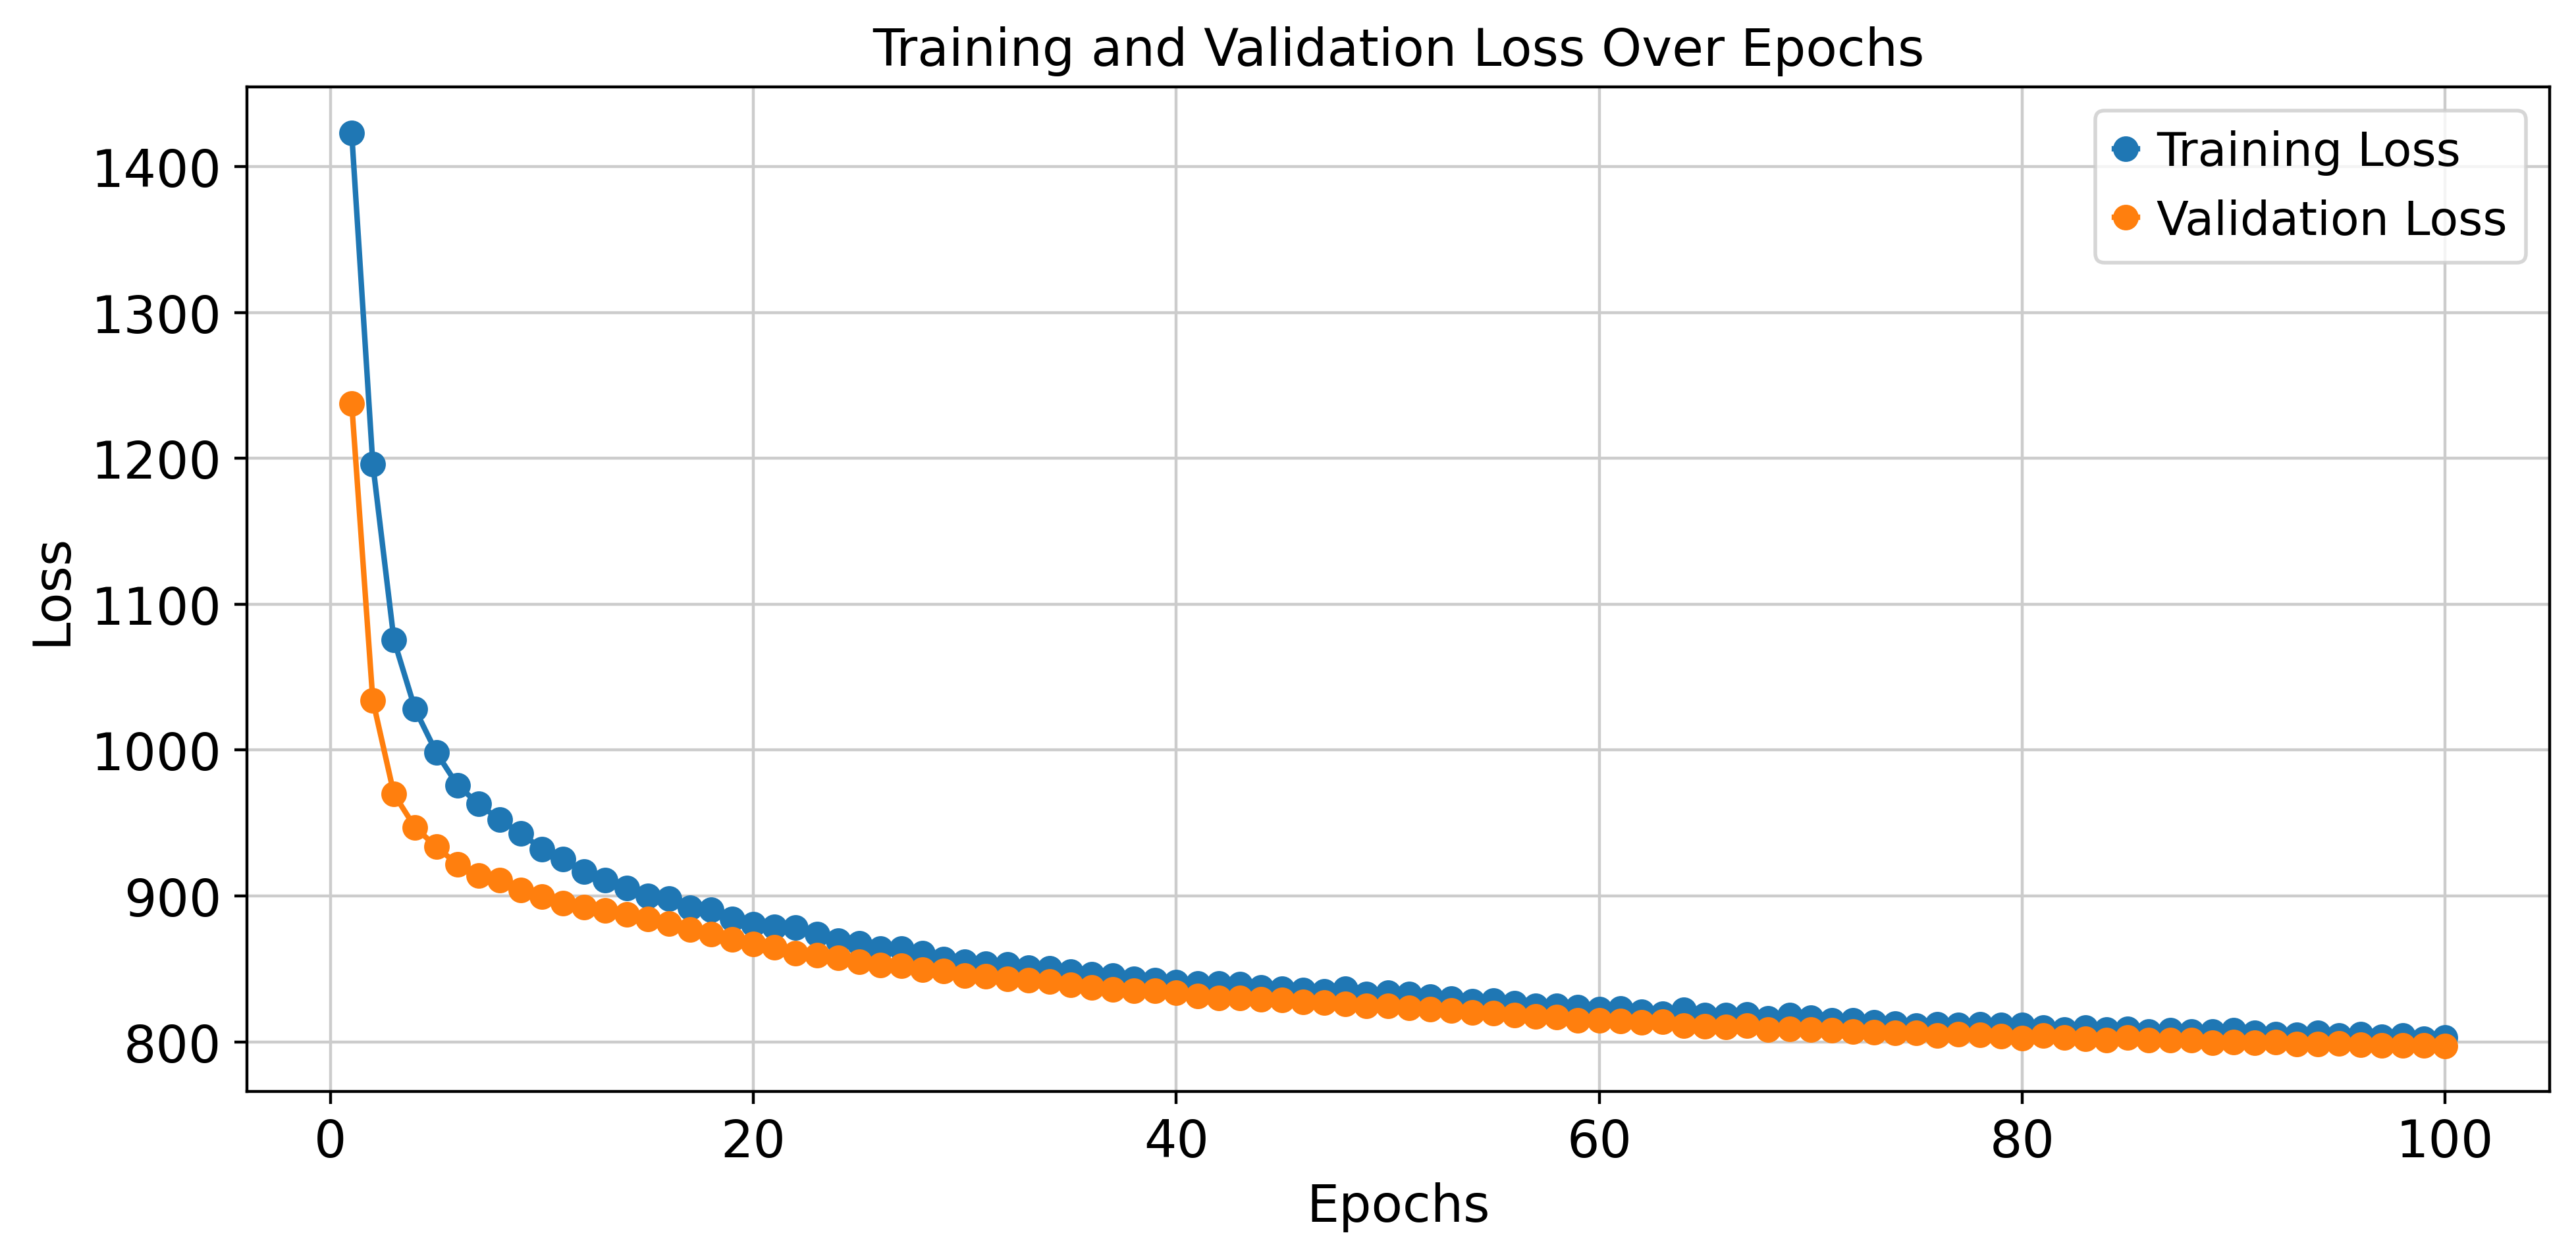

In [24]:
# Visualize Training History
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot Losses
    plt.plot(epochs, history['train_loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if 'history' in locals():
    plot_training_history(history)
else:
    print("History object not found. Please run the training cell first.")

In [26]:
## Model Inference
model.eval()
cond = adata.obs['batch'].values
labels = np.zeros(cond.shape[0], dtype=np.int64)

x = torch.Tensor(adata.X.astype(np.float32))
x = torch.log1p(x)

for condition, label in model.condition_encoder.items():
    labels[cond == condition] = label
c = torch.tensor(labels, device=device)
tcremb = torch.tensor(adata.obsm['tcremb'].astype(np.float32), device=device)

batch_size = 512
n_samples = x.shape[0]

gene_latents, tcr_latents, poe_latents = [], [], []
for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    idx = slice(start, end)

    x_batch = x[idx].to(device)
    tcremb_batch = tcremb[idx]

    # encoder
    gene_latent, gene_logvar = model.gene_encoder(x_batch)
    tcr_latent, tcr_logvar = model.tcr_encoder(tcremb_batch)

    # fusion
    lamda = 0.5
    poe_latent = model.layer_norm(lamda * gene_latent + (1 - lamda) * tcr_latent)

    # output
    gene_latents.append(gene_latent.cpu().detach())
    tcr_latents.append(tcr_latent.cpu().detach())
    poe_latents.append(poe_latent.cpu().detach())

# combine batch level embeddings
gene_emb = torch.cat(gene_latents, dim=0).numpy()
tcr_emb  = torch.cat(tcr_latents,  dim=0).numpy()
poe_emb  = torch.cat(poe_latents,  dim=0).numpy()

adata.obsm['tstscope_tcr'] = tcr_emb
adata.obsm['tstscope_gene'] = gene_emb
adata.obsm['tstscope_joint'] = poe_emb

## Visualization

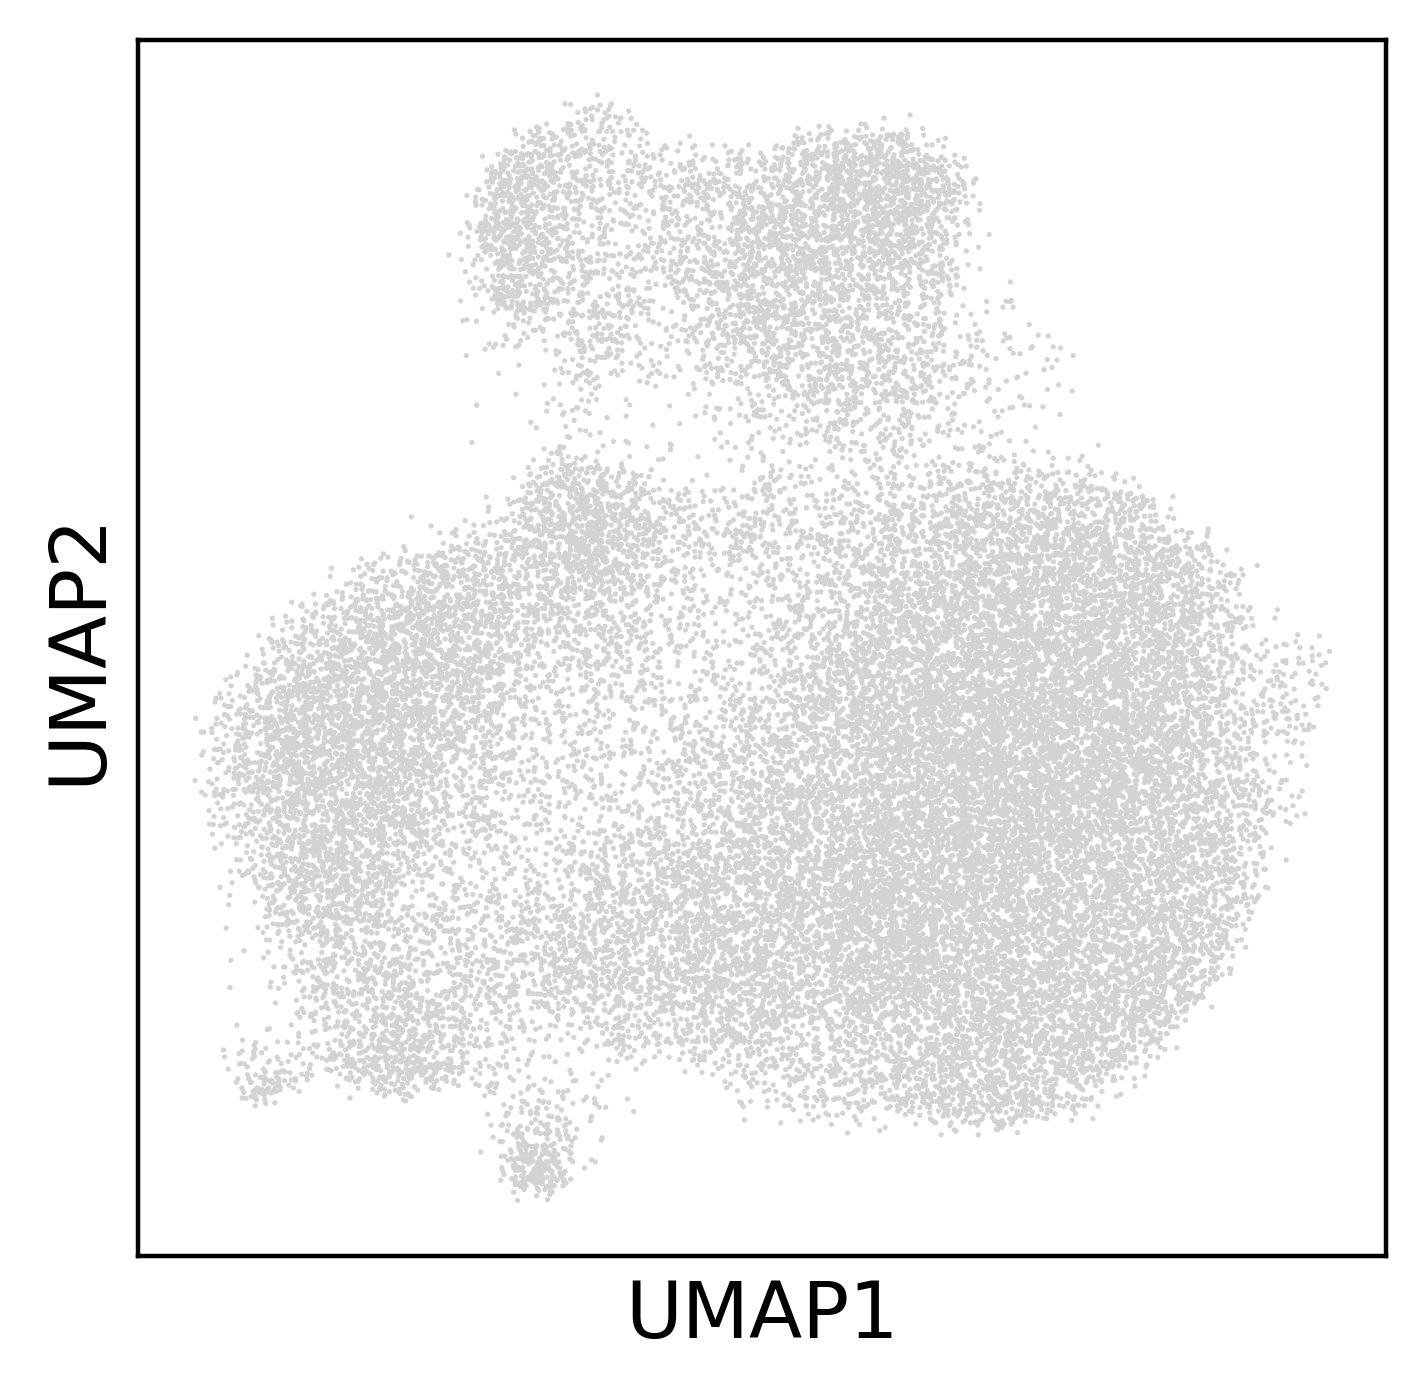

In [27]:
sc.pp.neighbors(adata, use_rep='tstscope_joint')
sc.tl.umap(adata)
sc.pl.umap(adata)

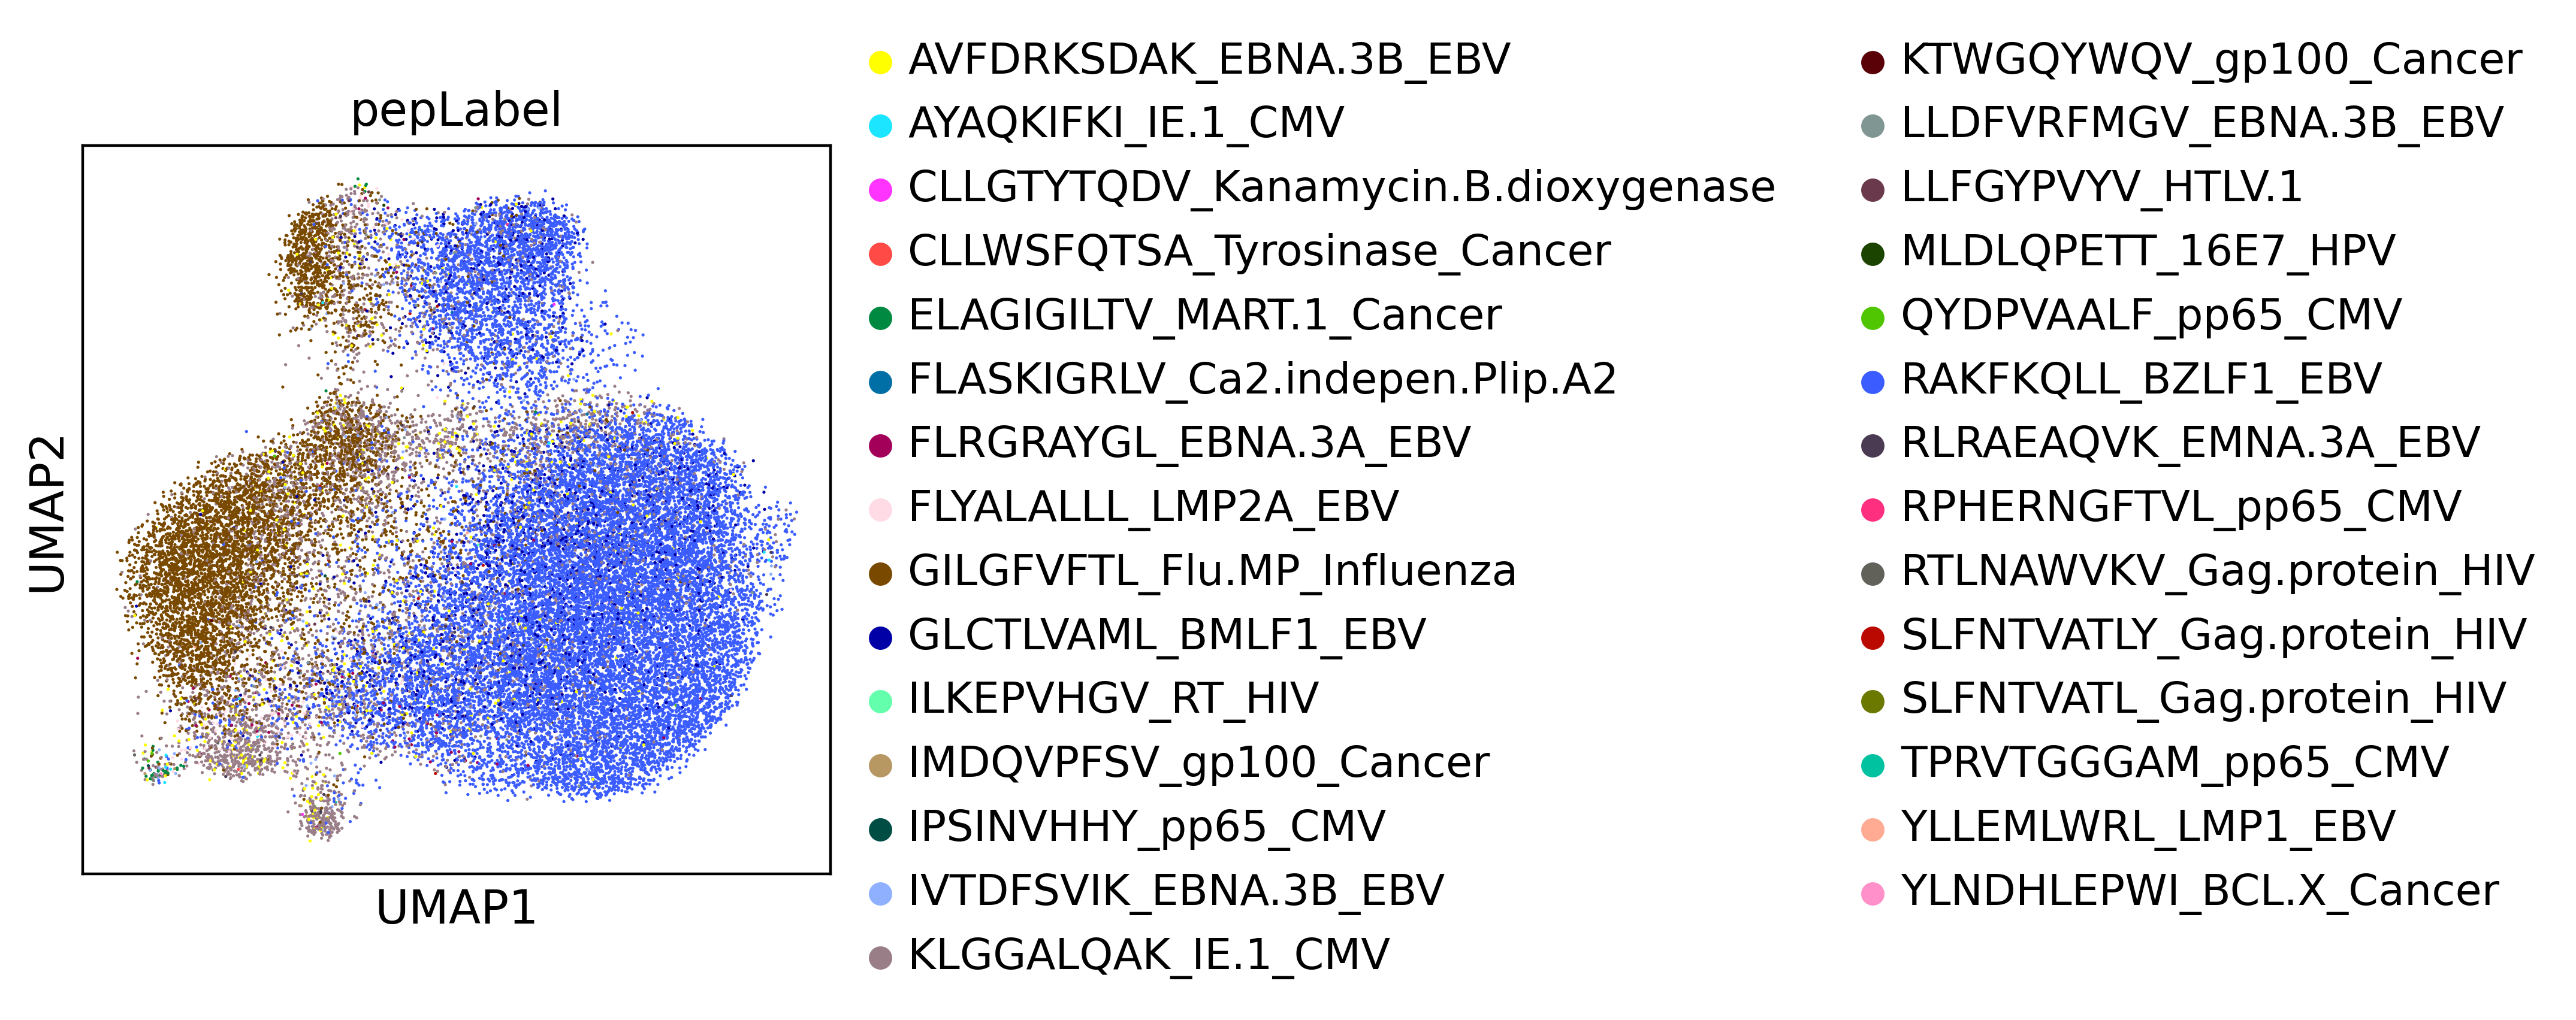

In [28]:
sc.pl.umap(adata, color='pepLabel')

In [30]:
adata

AnnData object with n_obs × n_vars = 33804 × 1123
    obs: 'nCount_RNA', 'nFeature_RNA', 'pepLabel', 'tra', 'trb', 'batch', 'tcrlabel'
    var: 'name'
    uns: 'terms', 'neighbors', 'umap', 'pepLabel_colors'
    obsm: 'scCVC_emb', 'tcrbert_emb', 'tcrbert_ft_emb', 'tcremb', 'tstscope_tcr', 'tstscope_gene', 'tstscope_joint', 'X_umap'
    varm: 'I'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [31]:
adata.write('../data/donor2_tcr_emb_SeuObj_TSTscope_0628.h5ad')